In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os

import matplotlib.pyplot as plt
import normflows as nf
import numpy as np
import seaborn as sns
import torch
import torchvision
import torchvision.datasets.utils as dataset_utils
from PIL import Image
from torchvision import datasets
from torchvision.datasets.mnist import MNIST
from torchvision.transforms import ToTensor

root = "/Users/adam2392/pytorch_data/"

import matplotlib.pyplot as plt
import torchvision.transforms.functional as F

plt.rcParams["savefig.bbox"] = "tight"
import numpy as np
import seaborn as sns

In [3]:
def add_bar(
    idx, bar, mnist, bar_val=255, start_height=0, height=4, start_width=0, width=None
):
    img = mnist[idx].clone().numpy().reshape(28, 28, 1)

    if width is None:
        width = img.shape[1]

    # add bar
    if bar == 1:
        img[
            start_height : start_height + height, start_width : start_width + width, -1
        ] = bar_val
    return img


def get_mnist_digit(images, labels, target):
    raw_images = []
    for image, label in zip(images, labels):
        if label == target:
            raw_images.append(image)
    return raw_images


def show(imgs):
    if not isinstance(imgs, list):
        imgs = [imgs]
    fix, axs = plt.subplots(ncols=len(imgs), squeeze=False)
    for i, img in enumerate(imgs):
        # img = img.detach()
        img = F.to_pil_image(img)
        axs[0, i].imshow(np.asarray(img))
        axs[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

In [4]:
import normflows as nf
import torchvision
from torchvision.datasets.mnist import MNIST

root = "/Users/adam2392/pytorch_data/"

# set up transforms for each image to augment the dataset
transform = torchvision.transforms.Compose(
    [
        torchvision.transforms.ToTensor(),
        nf.utils.Scale(255.0 / 256.0),  # normalize the pixel values
        nf.utils.Jitter(1 / 256.0),  # apply random generation
        torchvision.transforms.RandomRotation(350),  # get random rotations
    ]
)

mnist_data = MNIST(root, train=True, download=True, transform=transform)

images = mnist_data.data
labels = mnist_data.targets

images = get_mnist_digit(images, labels, 0)
print(len(images))

5923


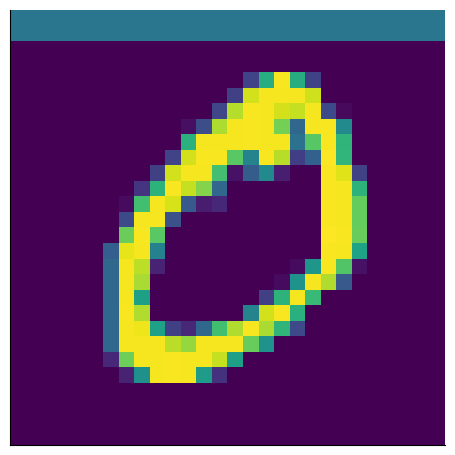

In [5]:
new_img = add_bar(0, 1, images, bar_val=100, height=2, start_height=0)


show([new_img])

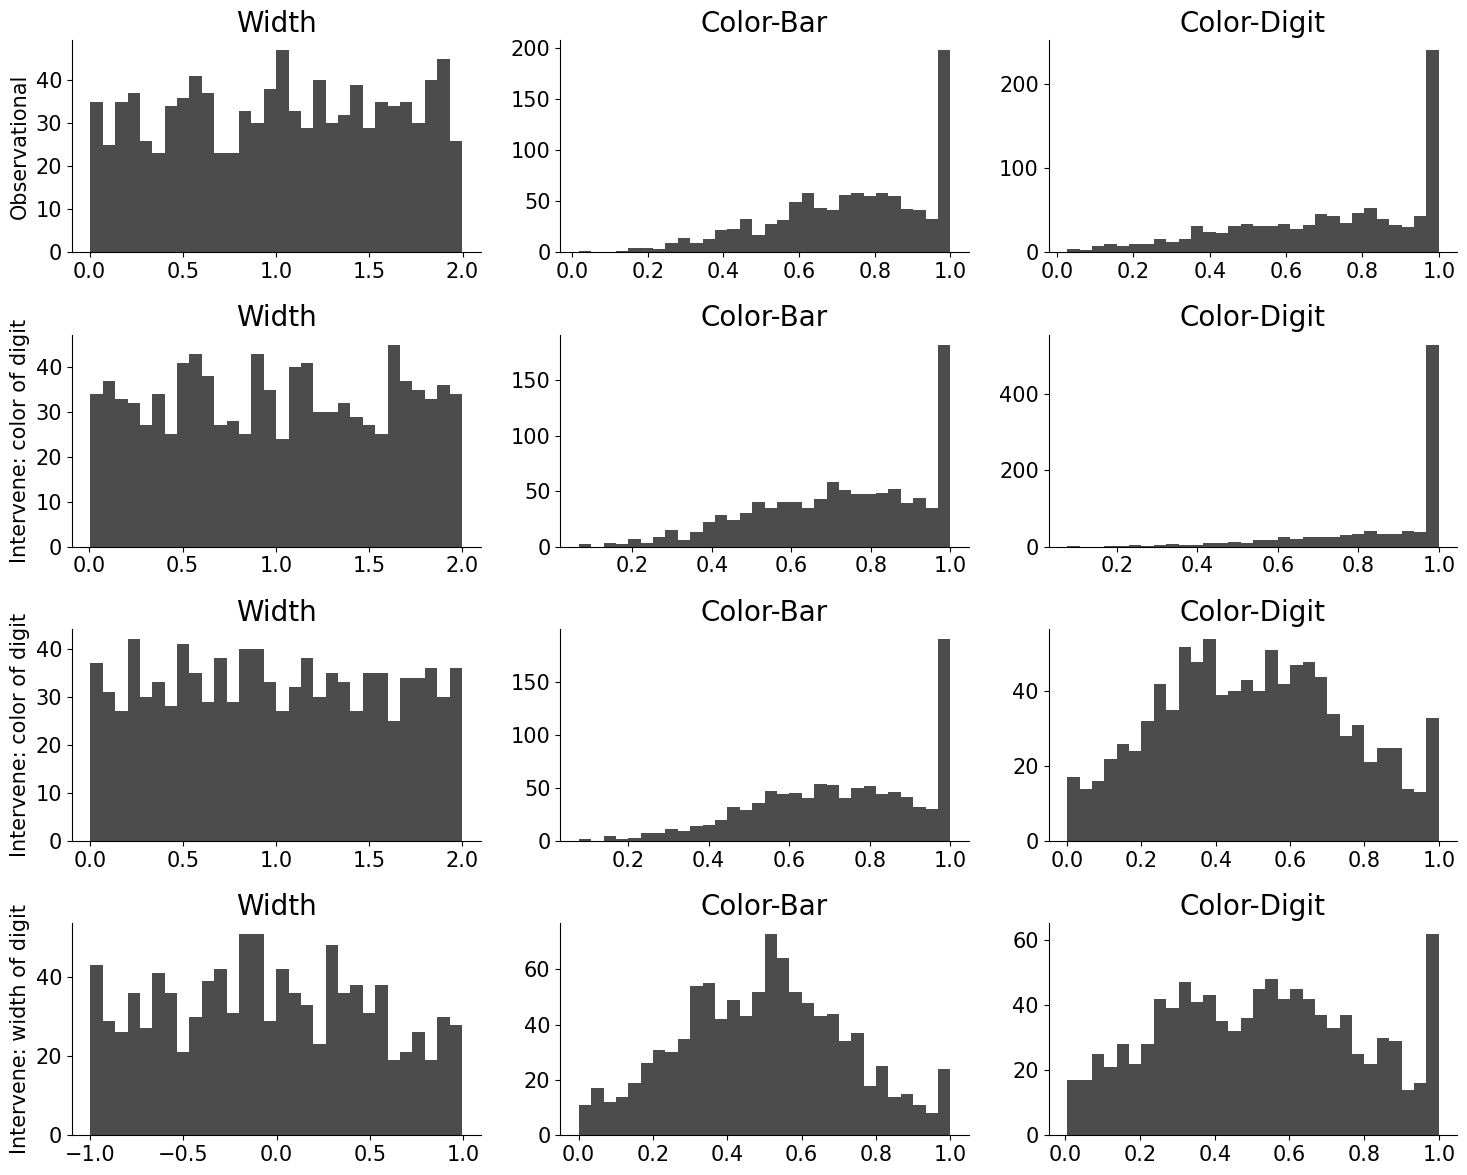

In [16]:
import numpy as np
import torch
from scipy.stats import truncnorm

# Number of samples
n_samples = 1000


def truncated_normal(mean, std, lower, upper, size):
    return truncnorm(
        (lower - mean) / std, (upper - mean) / std, loc=mean, scale=std
    ).rvs(size)


def post_process_color_digit(color_digit):
    zero_indices = color_digit == 0
    color_digit[zero_indices] = np.random.uniform(0, 1, zero_indices.sum())
    return color_digit


def bar_scm(n_samples, intervention_idx, label):
    meta_labels = dict()

    # Truncated normal distribution parameters
    mu_cd, sigma_cd = 0, 0.2
    mu_cb, sigma_cb = 0, 0.2
    width_lim = [0, 2]
    width = np.random.uniform(*width_lim, n_samples)

    if intervention_idx == 0:
        mu_cd, sigma_cd = 0, 0.2
    elif intervention_idx == 1:
        mu_cd, sigma_cd = 0.3, 0.2
    elif intervention_idx == 2:
        mu_cd, sigma_cd = -0.3, 0.2
    elif intervention_idx == 3:
        width_lim = [-1, 1]
        width = truncated_normal(0, 1, *width_lim, n_samples)

    # sample exogenous noise for color of digit and color of bar
    noise_cd = truncated_normal(mu_cd, sigma_cd, -0.5, 0.5, n_samples)
    noise_cb = truncated_normal(mu_cb, sigma_cb, -0.5, 0.5, n_samples)

    # Generate samples for observational setting
    color_bar = np.clip((width + 2) / 4 + noise_cb, 0, 1)
    color_bar = post_process_color_digit(color_bar)
    color_digit = np.clip(color_bar + noise_cd, 0, 1)
    color_digit = post_process_color_digit(color_digit)

    width = torch.Tensor(width)
    color_digit = torch.Tensor(color_digit)
    color_bar = torch.Tensor(color_bar)

    meta_labels["width"] = width.to(torch.float32)
    meta_labels["color_digit"] = color_digit.to(torch.float32)
    meta_labels["color_bar"] = color_bar.to(torch.float32)
    meta_labels["label"] = [label] * n_samples
    # add intervention targets
    if intervention_idx is None or intervention_idx == 0:
        meta_labels["intervention_targets"] = [[0, 0, 0]] * n_samples
    elif intervention_idx in [1, 2]:
        # intervene and change the distribution of the color-digit
        meta_labels["intervention_targets"] = [[0, 0, 1]] * n_samples
    elif intervention_idx in [3]:
        # intervene and change the distribution of the digit width
        meta_labels["intervention_targets"] = [[1, 0, 0]] * n_samples
    return meta_labels, width, color_bar, color_digit


# Plotting the distributions
fig, axes = plt.subplots(4, 3, figsize=(15, 12), sharex=False, sharey=False)

for idx in range(4):
    meta_labels, width, color_bar, color_digit = bar_scm(
        n_samples=1000, intervention_idx=idx, label=0
    )
    if idx == 0:
        setting = "Observational"
    elif idx == 1:
        setting = "Intervene: color of digit"
    elif idx == 2:
        setting = "Intervene: color of digit"
    elif idx == 3:
        setting = "Intervene: width of digit"
    axes[idx, 0].set_ylabel(f"{setting}")

    axes[idx, 0].hist(width, bins=30, color="black", alpha=0.7)
    axes[idx, 0].set_title(f"Width")
    axes[idx, 1].hist(color_bar, bins=30, color="black", alpha=0.7)
    axes[idx, 1].set_title(f"Color-Bar")
    axes[idx, 2].hist(color_digit, bins=30, color="black", alpha=0.7)
    axes[idx, 2].set_title(f"Color-Digit")

plt.tight_layout()
plt.show()

In [23]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import truncnorm
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms

from gendis.datasets.morphomnist import morpho, perturb


# Function to generate truncated normal noise
def truncated_normal(mean, std, lower, upper, size):
    return truncnorm(
        (lower - mean) / std, (upper - mean) / std, loc=mean, scale=std
    ).rvs(size)


# Function to uniformly distribute clipped values of color_digit
def post_process_color_digit(color_digit):
    zero_indices = color_digit == 0
    color_digit[zero_indices] = np.random.uniform(0, 1, zero_indices.sum())
    return color_digit


# Function to generate samples for the given intervention index
def bar_scm(n_samples=1000, intervention_idx=0):
    width = np.random.uniform(0, 2, n_samples)

    alpha_cd, beta_cd = 2, 5
    shift_cd = -0.25

    noise_cd = np.random.beta(alpha_cd, beta_cd, n_samples) - 0.5 + shift_cd
    color_digit = np.clip((width + 2) / 4 + noise_cd, 0, 1)
    color_digit = post_process_color_digit(color_digit)

    if intervention_idx == 0:  # Observational setting
        mu_cb, sigma_cb = 0, 0.2
    elif intervention_idx == 1:  # First intervention on color-bar
        mu_cb, sigma_cb = 0.3, 0.2
    elif intervention_idx == 2:  # Second intervention on color-bar
        mu_cb, sigma_cb = 0.6, 0.1
    else:
        raise ValueError("Invalid intervention index")

    noise_cb = truncated_normal(mu_cb, sigma_cb, -0.5, 0.5, n_samples)
    color_bar = np.clip(color_digit + noise_cb, 0, 1)

    return width, color_digit, color_bar


def add_bar(
    img, color_bar_val=255, start_height=0, height=3, start_width=0, width=None
):
    if width is None:
        width = img.shape[1]

    # add bar
    for color_idx in range(3):
        img[
            start_height : start_height + height,
            start_width : start_width + width,
            color_idx,
        ] = (
            color_bar_val[color_idx] * 255.0
        )
    return img


# Placeholder for alter_img function
def alter_img(img, width, color_digit, color_bar):
    cmap = plt.cm.viridis

    # Apply transformations to the image based on the parameters
    # This is just a placeholder, you need to implement the actual transformation logic
    # apply width changes
    if width < 1.0:
        width_func = perturb.Thinning(amount=width)
    else:
        width_func = perturb.Thickening(amount=width)
    # fracture = perturb.Fracture(thickness=6, num_frac=1)
    # swelling = perturb.Swelling(strength=2, radius=3)

    img = img.squeeze()
    for perturb_func in [width_func]:
        img = torch.Tensor(np.array(img))
        img = apply_perturbation(img, perturb_func, convert_dtype=False)

    # change the color
    h, w = img.shape
    # print(color_digit, color_bar)
    color_value = np.array(cmap(color_digit)[:3]).squeeze()
    colored_arr = np.zeros((h, w, 3), dtype=np.uint8)
    mask = img > 0  # Mask to identify the digit
    for i in range(3):
        colored_arr[:, :, i][mask] = (
            color_value[i] * 255
        )  # Apply uniform color to the digit
    img = colored_arr

    # add bar
    color_value = np.array(cmap(color_bar)[:3]).squeeze()
    img = add_bar(
        img,
        color_bar_val=color_value,
        start_height=0,
        height=4,
        start_width=0,
        width=None,
    )

    return img


def apply_perturbation(image, perturbation, convert_dtype=True):
    # Convert image to binary
    image = image.squeeze().numpy()
    binary_image = np.array(image) > 0

    # print(image.shape)
    # print(np.sum(image.flatten()))
    morph = morpho.ImageMorphology(binary_image, 
                                   # threshold=0.4, scale=4
                                  )
    # try:
    perturbed_image = perturbation(morph)
    # except Exception as e:
    #     print(np.sum(binary_image))
    #     perturbed_image = binary_image
    #     print(e)

    # return
    # perturbed_image = morph.downscale(perturbed_image)
    if convert_dtype:
        return Image.fromarray((perturbed_image * 255).astype(np.uint8))
    else:
        return perturbed_image * 255


# Function to create a new dataset
def create_altered_mnist_dataset(mnist_loader, n_samples=1000, intervention_idx=0):
    altered_images = []
    labels = []

    width, color_digit, color_bar = bar_scm(n_samples, intervention_idx)

    for i, (img, label) in enumerate(mnist_loader):
        if i >= n_samples:
            break
        # img = img.squeeze().numpy().copy()
        print(width[i], color_digit[i], color_bar[i])
        altered_img = alter_img(img, width[i], color_digit[i], color_bar[i])
        altered_images.append(altered_img)
        labels.append(label.item())

    return np.array(altered_images), np.array(labels)


# Custom dataset to filter images of digit 0
class DigitZeroDataset(Dataset):
    def __init__(self, mnist_dataset):
        self.data = [img for img, label in mnist_dataset if label == 0]
        self.data = np.stack(self.data)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx], 0

In [24]:
print(root)

/Users/adam2392/pytorch_data/


5923
1.6256874002325135 0.775204979679373 0.4947391688039985
0.6774855780424225 0.1232232526938235 0.0761548303779837
0.769672253829411 0.06371548668925442 0.01752657675050645
0.39560289548627314 0.19009029648548387 0.11459845647702117
0.1305563742787863 0.050679392760321684 0.11807111767329574
0.5844052550738581 0.15519773213200755 0.08327323074164257
1.616422868699997 0.3004031161711106 0.5709310481538652
0.6751568780827715 0.2957825015286858 0.2489187402198514
0.17917194791064195 0.44276079646089816 0.6903627960638123


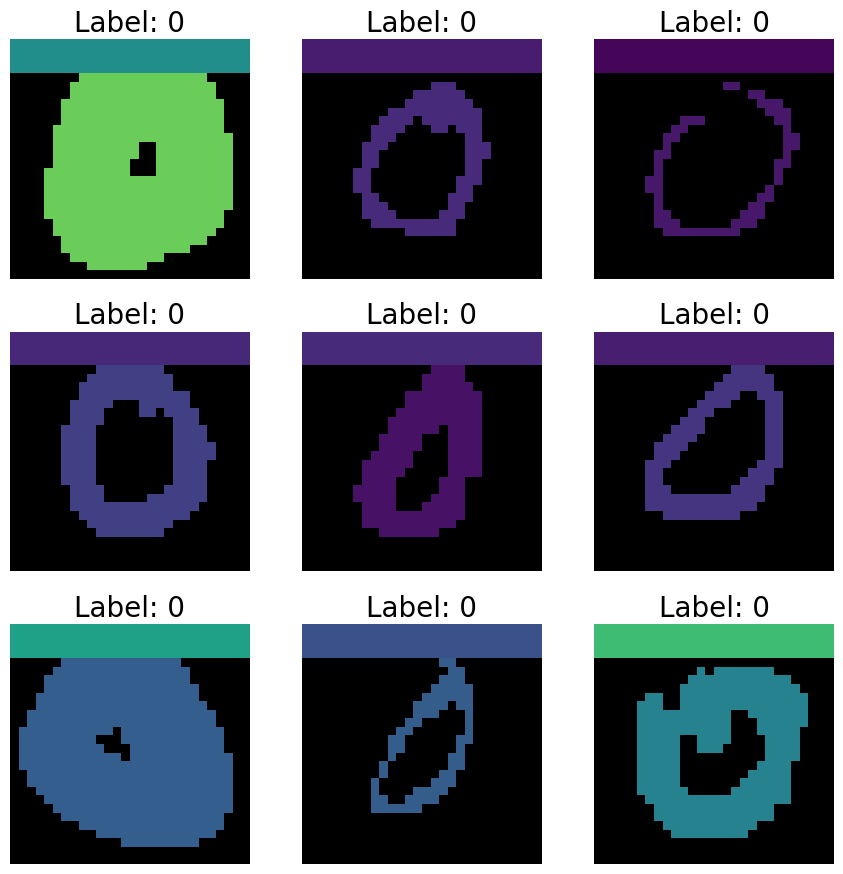

In [25]:
# Load MNIST dataset
transform = transforms.Compose([transforms.ToTensor()])
mnist_dataset = datasets.MNIST(
    root=root,
    train=True,
    download=True,  # transform=transform
)
digit_zero_dataset = DigitZeroDataset(mnist_dataset)
mnist_loader = DataLoader(digit_zero_dataset, batch_size=1, shuffle=True)
print(len(digit_zero_dataset))
# Generate a new dataset
altered_images, altered_labels = create_altered_mnist_dataset(
    mnist_loader, n_samples=9, intervention_idx=0
)

# Display some examples
fig, axes = plt.subplots(3, 3, figsize=(9, 9))
for i, ax in enumerate(axes.flatten()):
    ax.imshow(altered_images[i], cmap="gray")
    ax.set_title(f"Label: {altered_labels[i]}")
    ax.axis("off")

plt.tight_layout()
plt.show()